<a href="https://colab.research.google.com/github/Samuel-CHLam/Oxford_Taught_Deep_Learning/blob/main/Theory_of_Deep_Learning_MT2022_PS1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Training Networks
In this section we will build two Neural Networks, one from scratch, and one based on the high-level functions provided by Tensorflow.

We will build a net from scratch to solve the XOR problem, and to do this we will rely on the backpropagation formulae that you will derive. We will also build a network with Tensorflow to introduce you to their API.

**Part (a)**: Consider a standard feedforward network defined by $h_1 = x$ and $h_{j+1} = \sigma(W^{(j)} h_j + b^{(j)})$ for $j = 1,..., N − 1$, and define the loss as the sum of squared errors, $L(b,W) = \sum_{i=1}^n \|h_N(x_i) − y_i\|^2$. Derive the formulae used for ‘backpropagation’, which would be used to update the weights and biases in the network when optimising the loss function using gradient descent.

*Solution.* We first derive the backpropagation for the $j=N-1$ weights and bias. For simplicity, we define $z^{(j)} = W^{(j)} h_j + b^{(j)}$, and we adopt the notation of $[z]_k$ being the $k$-th entry of the vector $z$. 

We note that $L(b,W) = \sum_{i=1}^n L_i(b,W)$ where $L_i(b,W) = \|h_N(x_i) - y_i \|^2$. We will derive the derivatives for $L_i$ -- the derivatives for $L$ is the sum of derivatives for $L_i$. We finally note that 

$$
\begin{aligned}
L_i(b,W) &= \sum_{k} [h_N(x_i) - y_i]^2_k \\
&= \sum_{k} [\sigma(z^{(N-1)}) - y_i]^2_k \\
&= \sum_{k} \left(\left[\sigma(W^{(N-1)} h_{N-1} + b^{(N-1)})\right]_k - [y_i]_k \right)^2 \\
&= \sum_{k} \left(\sigma \left( [W^{(N-1)} h_{N-1}]_k + b^{(N-1)}_k \right) - [y_i]_k \right)^2 \\
&= \sum_{k} \left(\sigma \left( \sum_{\ell} W^{(N-1)}_{k,\ell} h^{(N-1)}_\ell + b^{(N-1)}_k \right) - [y_i]_k \right)^2
\end{aligned}$$

We then have
$$
\frac{\partial L_i}{\partial z^{(N-1)}_k} = 2\left(\sigma \left( z^{(N-1)}_k \right) - [y_i]_k \right) \sigma'(z^{(N-1)}_k),
$$
and 
$$
\frac{\partial L_i}{\partial b^{(N-1)}_k} = \frac{\partial L}{\partial z^{(N-1)}_k} = 2\left(\sigma \left( z^{(N-1)}_k \right) - [y_i]_k \right) \sigma'(z^{(N-1)}_k).
$$

Moreover, we have
$$\frac{\partial L_i}{\partial W^{(N-1)}_{k,\ell}} = 2\left(\sigma \left( z^{(N-1)}_k \right) - [y_i]_k \right) \sigma'(z^{(N-1)}_k) h_\ell^{(N-1)}$$

As a result, we have the following total derivatives:
$$\nabla_{b^{(N-1)}} L_i = 2(h_N(x_i) - y_i) \odot \sigma'(z^{(N-1)})$$
and 
$$\nabla_{W^{(N-1)}} L_i= 2\left[(h_N(x_i) - y_i) \odot \sigma'(z^{(N-1)}) \right] \left(h_{N-1} \right)^\top$$

Let us also record the following result:
$$\frac{\partial L_i}{\partial [h_{N-1}]_\ell} = 2\left(\sigma \left( z^{(N-1)}_k \right) - [y_i]_k \right) \sigma'(z^{(N-1)}_k) W_{k,\ell}$$

Since $W_{k,\ell} = W^\top_{\ell,k}$, we have
$$\nabla_{h^{(N-1)}} L_i = 2(W^{(N-1)})^\top \left[(h_N(x_i) - y_i) \odot \sigma'(z^{(N-1)}) \right]$$

We may follow similar method to derive the recursive formula for "backpropagation". In fact, we have, for $j \leq N-1$,

$$
\begin{aligned}
\nabla_{b^{(j-1)}} L_i &= \nabla_{h^{(j)}} L_i \odot \sigma'(z^{(j-1)}) \\
\nabla_{W^{(j-1)}} L_i &= \nabla_{h^{(j)}} L_i \odot \sigma'(z^{(j-1)}) \left(h_{j-1} \right)^\top \\
\nabla_{h^{(j-1)}} L_i &= \left(W^{(j-1)} \right)^\top \nabla_{h^{(j)}} L_i
\end{aligned}
$$

**Part (b) XOR problem - NN from Scratch**

In this problem we have four possible inputs with two possible outcomes; 

 
> $x_1 = 0, x_2 = 0 \Rightarrow XOR(x_1,x_2)=0$

> $x_1 = 0, x_2 = 1 \Rightarrow XOR(x_1,x_2)=1$

> $x_1 = 1, x_2 = 0 \Rightarrow XOR(x_1,x_2)=1$

> $x_1 = 1, x_2 = 1 \Rightarrow XOR(x_1,x_2)=0$

In the problem sheet you may have noticed that a two layer NN  could solve this problem exactly. Here we will see that on a 2-layer net with Sigmoid activation functions, with a random intialisation and the mean square loss, back-prop is able to converge to a pseudo-optimal solution. We will then consider a visualisation of how the neural network divides the input space as a classifier.



**Exercise** The class for the NeuralNet is already defined except for the backpropagation function, which you have to complete.

Note: Once you have implemented backprop, if you get poor performance, try running the cell again.

In [3]:
import numpy as np

def sigmoid(x):
    return 1.0/(1+ np.exp(-x))
    
def sigmoid_derivative(x):
    return x * (1.0 - x)

class NeuralNetwork:
    def __init__(self, x, y):
        dimension = 2
        self.input        = x
        self.weights1     = np.random.rand(dimension, x.shape[1])      #np.array([[-1,1],[1,-1]], dtype=np.float)
        self.weights2     = np.random.rand(1,dimension)      
        self.bias1        = np.random.rand(dimension,1)      #0.5*np.ones((dimension,1))
        self.bias2        = np.random.rand(1,1)           
        self.y            = y
        self.output       = np.zeros(self.y.shape)
        self.activation   = sigmoid
        self.d_activation = sigmoid_derivative

    def feedforward(self,x):
        self.x = np.expand_dims(x,axis =1)
        self.layer1 = self.activation(self.weights1 @  self.x + self.bias1)
        self.output = self.activation(self.weights2 @ self.layer1 + self.bias2)

    def call(self,x):
        x = np.expand_dims(x,axis =1)
        layer1 = self.activation(self.weights1 @  x + self.bias1)
        output = self.activation(self.weights2 @ layer1 + self.bias2)
        return output

    def backprop(self):
        # application of the chain rule to find derivative of the loss function with respect to weights2 and weights1
        d_weights1 = np.zeros(self.weights1.shape)
        d_weights2 = np.zeros(self.weights2.shape)
        d_bias1    = np.zeros(self.bias1.shape)
        d_bias2    = np.zeros(self.bias2.shape)
        
        for j in range(4):
          # compute gradient per each input image
          single_input = self.input[j]
          self.feedforward(single_input)

          d_bias2    += 2 * (self.output - self.y[j][0]) * sigmoid_derivative(self.output) 
          d_weights2 += 2 * ((self.output - self.y[j][0]) * sigmoid_derivative(self.output)) @ self.layer1.T
          d_h1       =  2 * self.weights2.T @ ((self.output - self.y[j][0]) * sigmoid_derivative(self.output))
          d_bias1    += d_h1 * sigmoid_derivative(self.layer1)
          d_weights1 += (d_h1 * sigmoid_derivative(self.layer1)) @ single_input.reshape(-1,1).T

        self.weights1 -= d_weights1
        self.weights2 -= d_weights2
        self.bias1    -= d_bias1
        self.bias2    -= d_bias2

In [4]:
X = np.array([[0,0],
              [0,1],
              [1,0],
              [1,1]])
y = np.array([[0],[1],[1],[0]])

nn = NeuralNetwork(X,y)

In [5]:
from tqdm import tqdm
for i in tqdm(range(10000)):
    nn.backprop()
for j in range(4):
    nn.feedforward(X[j])
    print('Prediction:\n', nn.x, ' --->' , nn.output)

100%|██████████| 10000/10000 [00:06<00:00, 1595.88it/s]

Prediction:
 [[0]
 [0]]  ---> [[0.00901307]]
Prediction:
 [[0]
 [1]]  ---> [[0.9923452]]
Prediction:
 [[1]
 [0]]  ---> [[0.99234973]]
Prediction:
 [[1]
 [1]]  ---> [[0.007837]]


Now we will plot how the domain has been split. In the left figure we will see the outputs of the NN, while on the right we visualise the classification of these outputs i.e. any value above 0.5 identifies class 1, 0 otherwise, which shows us the decision boundary of the classifier.


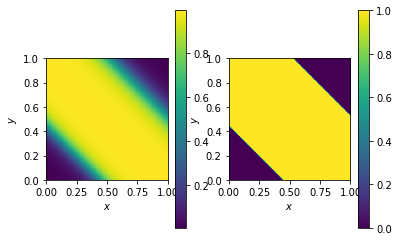

In [6]:
import matplotlib.pyplot as plt

mu = np.linspace(0,1,100)
gamma = np.linspace(0,1,100)

# filling the heatmap, value by value
fun_map = np.empty((mu.size, gamma.size))
for i in range(mu.size):
    for j in range(gamma.size):
        net_val = nn.call([mu[i], gamma[j]])
        if net_val>0.5:
          fun_map[i,j] = 1
        else:
          fun_map[i,j] = 0

fun_map_2 = np.empty((mu.size, gamma.size))
for i in range(mu.size):
    for j in range(gamma.size):
        fun_map_2[i,j] = nn.call([mu[i], gamma[j]])

fig = plt.figure()
s = fig.add_subplot(1, 2, 1, xlabel='$x$', ylabel='$y$')
im = s.imshow(
    fun_map_2,
    extent=(gamma[0], gamma[-1], mu[0], mu[-1]),
    origin='lower')
fig.colorbar(im)
s = fig.add_subplot(1, 2, 2, xlabel='$x$', ylabel='$y$')
im = s.imshow(
    fun_map,
    extent=(gamma[0], gamma[-1], mu[0], mu[-1]),
    origin='lower')
fig.colorbar(im)


N.B. The transition fase with the sigmoid activation function is sharp, and so the NN more-or-less splits the domain into piecwise constant regions.

**Part (c): Training MNIST.** First, we have to upload the dataset; keras, an interface for tensorflow, allows us to do this with a one line command. We then can use the Sequence model class from TF to add different layers to our network.



In [ ]:
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels)= mnist.load_data()

print(train_images.shape) # Check if images are loaded correctly

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)


**Exercise** You now have to generate a two layer network with hidden dimension of 128 via the sequential command in Tensorflow. This should allow you to achieve 92% accuracy with only 15 epochs of training!!

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras import Input
from keras.utils import to_categorical

# Generate data
x_train = train_images
y_train = train_labels

x_test = test_images
y_test = test_labels

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# build the architecture with Sequential
model = Sequential()
model.add(Input(shape=(28,28)))
model.add(Flatten())
model.add(Dense(128, activation="sigmoid"))
model.add(Dense(10, activation="sigmoid"))

# Compile the model, which involved shows a loss function, an optimiser, and the performance metrics you want to track
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=["accuracy"])

model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_18 (Flatten)        (None, 784)               0         
                                                                 
 dense_37 (Dense)            (None, 128)               100480    
                                                                 
 dense_38 (Dense)            (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# train the architecture
model.fit(x_train, y_train, epochs=15)

Epoch 1/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3461 - accuracy: 0.9080
Epoch 2/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3006 - accuracy: 0.9188
Epoch 3/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2807 - accuracy: 0.9207
Epoch 4/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2597 - accuracy: 0.9271
Epoch 5/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2444 - accuracy: 0.9312
Epoch 6/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2390 - accuracy: 0.9324
Epoch 7/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2295 - accuracy: 0.9354
Epoch 8/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2172 - accuracy: 0.9382
Epoch 9/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2105 - accuracy: 0.9409
Epoch 10/15
1875/1875 [==============================] - 6s 3ms/step - loss: 0.204

In [ ]:
# test the performance
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.2586 - accuracy: 0.9228


[0.2586139142513275, 0.9228000044822693]

# 2. Expressivity

**Part (a):** In Yarotsky (2016) it is proven that $f(x) = x^2$ on $[0, 1]$ can be approximated with any error $\varepsilon > 0$ by a ReLU network having the depth and the number of weights and computation units $O(\log(1/\varepsilon))$. The proof relies on the following statement:

**Claim:** Let $f_m$ be the piece-wise linear interpolation of $f(x) = x^2$ with $2^m+1$ uniformly distributed breakpoints $k$ , $k = 0,...,2^m$. The function $f$ approximates $f$ with the error $\epsilon = 2^{−2m−2}$ (in the $\ell^\infty$ norm).

Prove this statement.

*Solution.* We note the following general result: let $f(x) = x^2$ on $x \in [a,b]$ and $g(x)$ be its linear interpolation between the points $(a,a^2)$ and $(b,b^2)$, where $0\leq a<b \leq 1$. Then we have 
$$
  g(x) = \frac{b^2-a^2}{b-a}(x-a) + a^2 \geq f(x), \quad \forall x \in [a,b]
$$
We would like to find the maximum of $h(x) = g(x) - f(x)$. We note that
$$
  h'(x) = \frac{b^2-a^2}{b-a} - 2x, \quad h(x^*) = 0 \text{ when } x^* = \frac{b^2-a^2}{2(b-a)}
$$
Here $x^*$ is a maximum over $[a,b]$, because $h''(x) = -2 < 0$. Now we have
$$
\sup_{x \in [a,b]} |h(x)| = h(x^*) = 2x^* (x^* - a) + a^2 - (x^*)^2 = (x^* - a)^2.
$$
With this general result, we can plug in $a = k/2^m$ and $b = (k+1)/2^m$ for any $k = 0,...,2^m-1$. This leads to $x^* = (2k+1)/2^{m+1}$, and hence we conclude that the $\ell^\infty$ norm of approximation is
$$
\sup_{x\in [0,1]}|f_m(x) - f(x)| = \left(\frac{2k+1}{2^{m+1}} - \frac{k}{2^m} \right)^2 = 2^{-2m-2}.
$$

**Part (b):** Recall from lectures that the ‘sawtooth’ function can be created by iteratively composing the single-hidden-layer network $f(x) = \sigma(2\sigma(x) − 4\sigma(x − 1/2))$, where $\sigma(x) = x_+ = max(x, 0)$. Can the same be achieved with a network of the same width and depth if hard-tanh activations are used instead of ReLU? If so, write down the corresponding function.

*Solution.* Yes! Writing $\sigma$ as the $\mathsf{hardtanh}$ function, then the following function is a sawtooth
$$f(x) = \frac{1}{2}{\sigma(4x-1) - \sigma(4x-3)}.$$

**Part (c):** Consider $n$-ap problem (the $n$-alternating-point problem). Dataset consisting of a set of $n$ uniformly spaced points within $[0, 1 − 2^{−n}]$ with alternating labels, i.e., the pairs $(x_i, y_i)$ with $x_i = i2^{−n}$, and $y_i = 0$ when $i$ is even. How many layers does a width-2 ReLU network need in order to have the capacity to solve the $n$-ap problem? How wide would the layers need to be if there were only two layers?

*Solution.* We need at least $2n$ layers for a width-2 ReLU network to solve the $n$-ap problem. We need $2^n$ layers for a 2-layer ReLU network to solve the $n$-ap problem.

**Part (d): Train NN on n-ap probem.** The **$n$-ap problem** was shown to have an optimal solution with a particular construction of neural network. Do we find these coefficients/weights when training a network with that structure from randomly initialised weights?

Let's create an K-ap dataset for K = 3 and visualize the points by plotting. Then implement and train a network of the minimum necessary depth (identified in the previous question) to solve the n-ap problem for n = 3 (i.e. 8 points) (see the code outline in the attached notebook). How well does it perform? Does it converges?

*Comment:* It does not converge!

In [14]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import Input

# Generate data
X = np.array([[0],
                  [.125],
                  [.25],
                  [.375],
                  [.5],
                  [.625],
                  [.75],
                  [.875]])
y = np.array([[0],[1],[0],[1],[0],[1],[0],[1]])
x_train = X
y_train = y

# Build a model
model = Sequential()
model.add(Input(shape=(1)))
model.add(Dense(2, activation="relu"))
model.add(Dense(2, activation="relu"))
model.add(Dense(2, activation="relu"))
model.add(Dense(2, activation="relu"))
model.add(Dense(2, activation="relu"))
model.add(Dense(2, activation="relu"))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=5)

scores = model.evaluate(X, y)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

ynew = model.predict(x_train)
for i in range(len(x_train)):
	print("Y=%s, Predicted=%s" % (y_train[i], ynew[i]))

Epoch 1/5
1/1 [==============================] - 1s 1s/step - loss: 7.7125 - accuracy: 0.5000
Epoch 2/5
1/1 [==============================] - 0s 16ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 3/5
1/1 [==============================] - 0s 14ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 4/5
1/1 [==============================] - 0s 16ms/step - loss: 7.7125 - accuracy: 0.5000
Epoch 5/5
1/1 [==============================] - 1s 735ms/step - loss: 7.7125 - accuracy: 0.5000

accuracy: 50.00%
1/1 [==============================] - 0s 74ms/step
Y=[0], Predicted=[0. 0.]
Y=[1], Predicted=[0. 0.]
Y=[0], Predicted=[0. 0.]
Y=[1], Predicted=[0. 0.]
Y=[0], Predicted=[0. 0.]
Y=[1], Predicted=[0. 0.]
Y=[0], Predicted=[0. 0.]
Y=[1], Predicted=[0. 0.]


And now let's plot the modelled function




32/32 [==============================] - 0s 1ms/step


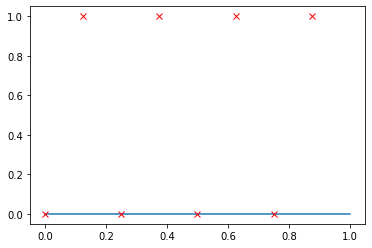

In [9]:
import matplotlib.pyplot as plt

def plot_model(nn,x,y):
  xx = np.linspace(0,1,1000).reshape(-1,1) # replaced with 10000
  yy = np.argmax(nn.predict(xx), axis=1)
  fig = plt.figure()
  plt.plot(xx,yy)
  plt.plot(x,y,'rx')
  
plot_model(model, x_train, y_train)

**Part (e): Perturbed Solution of the n-ap problem.** Why is this optimum so hard to find? Let's implement the optimal function directly and see how a small perturbation to the parameters changes the function it computes. What happens to the function? Does this tell us anything about the loss function which was optimised to train this network in the previous question?

*Solution.* The function changes quite a lot! I guess then it indicates that the loss function is very rough and contains lots of minimum!

In [55]:
# Fill in the weights and bias vactors given the optimal function to be composed, given in question 1b

w1 = np.array([[1], [1]])
b1 = np.array([[0], [-1/2]])
w2 = np.array([[2, -4]])

In [56]:
def relu(x):
  return np.maximum(x,0)

class f():
  def __init__(self, num_blocks, noise_stddev=0):
    self.weights  = []
    self.biases = []
    for i in range(num_blocks):
      w1_n = w1+ np.random.normal(scale = noise_stddev, size = w1.shape)
      w2_n = w2+ np.random.normal(scale = noise_stddev, size = w2.shape)
      b1_n = b1+ np.random.normal(scale = noise_stddev, size = b1.shape)
      self.weights.append([w1_n,w2_n])
      self.biases.append(b1_n)
  
  def forward(self,x):
    output = x
    for i in range(len(self.weights)):
      output = relu(self.weights[i][1] @ (relu(self.weights[i][0] @ output + self.biases[i])))
    return output

In [57]:
x = np.expand_dims(np.linspace(0,1,10000), 0)

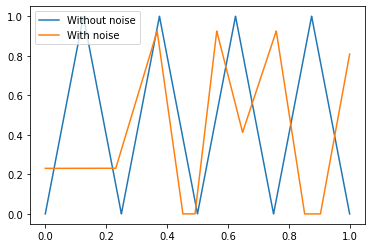

In [72]:
no_noise = f(3,0)
noise = f(3,0.1)

plt.figure()
plt.plot(x[0,:], no_noise.forward(x).T, label = "Without noise")

plt.plot(x[0,:], noise.forward(x).T, label = "With noise")
plt.legend()

**Part (f): Interatction Between Depth and Width.** Experiment with the associated Google Colab notebook code for approximating a one dimensional piecewise smooth function. Experiment with varying the width and depth of the network. In other lectures you will learn more about the training options, such as batch-size and various optimisation algorithms; the defaults in the code provided will not allow for high accuracy training. In order to contrast the depth versus width with ReLU activations you can compute the number of places where the slope changes in the generated function, and consider the width needed to achieve the same approximation with a depth 2 network. Also, try generating a two dimension piecewise smooth function and learn a network that approximates it.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

train_samples=10000

x_train=np.expand_dims(np.sort(np.random.uniform(0,1,train_samples)), 1)

#generate samples of y=sin(x * pi) for x\in[0,1) and y=x^2 for x\in[1/2,1]
def test_func(x):
    return np.sin(x*np.pi)*(x<1/2) + x**2*(x>=1/2)

y_train=test_func(x_train)

#uncommenting the below shows the samples
#plt.figure()
#plt.plot(x_train,y_train)

#we now train a network base on the samples (x_train,y_train) and evaluate it on x_test.

#consider varying the network width and depth, 
#width and depth are controlled through the variables "width" and "depths respectively", 

width=10
depth=10

model = Sequential()
model.add(Dense(width, input_dim=1, activation='relu'))

for i in range(depth-2):
  model.add(Dense(width, activation='relu'))

model.add(Dense(1))

model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer = 'adam',  metrics=['mse'])

model.fit(x_train, y_train, epochs=20, batch_size=32,verbose=1)

# scores = model.evaluate(X, y)
# print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/20
313/313 [==============================] - 1s 2ms/step - loss: 0.0822 - mse: 0.0822
Epoch 2/20
313/313 [==============================] - 1s 2ms/step - loss: 0.0384 - mse: 0.0384
Epoch 3/20
313/313 [==============================] - 1s 2ms/step - loss: 0.0063 - mse: 0.0063
Epoch 4/20
313/313 [==============================] - 1s 2ms/step - loss: 0.0040 - mse: 0.0040
Epoch 5/20
313/313 [==============================] - 1s 2ms/step - loss: 0.0036 - mse: 0.0036
Epoch 6/20
313/313 [==============================] - 1s 2ms/step - loss: 0.0033 - mse: 0.0033
Epoch 7/20
313/313 [==============================] - 1s 2ms/step - loss: 0.0026 - mse: 0.0026
Epoch 8/20
313/313 [==============================] - 1s 2ms/step - loss: 0.0033 - mse: 0.0033
Epoch 9/20
313/313 [==============================] - 1s 2ms/step - loss: 0.0024 - mse: 0.0024
Epoch 10/20
313/313 [==============================] - 1s 2ms/step - loss: 0.0026 - mse: 0.0026
Epoch 11/20
313/313 [============================

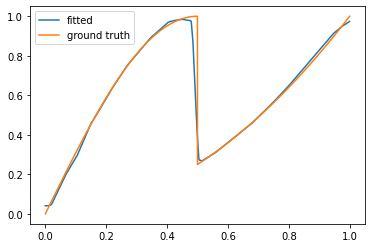

In [ ]:
x_test=np.linspace(0,1,10000)
y_test = test_func(x_test)

x_test = np.expand_dims(x_test,  axis=1)
y_test_estimate = model(x_test)

plt.figure()
plt.plot(x_test,y_test_estimate, label = "fitted")
plt.plot(x_test, y_test, label = "ground truth")
plt.legend()

Try and do something similar to the code above - but for a 2-d function
